In [1]:
pip install patchify

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

sys.path.append(os.path.join(os.getcwd(), '..', 'input', 'cbam-unet'))
sys.path.append(os.path.join(os.getcwd(), '..', 'input', 'road-segmentation-data-loader'))

from cbam_unet import *
from visualisation_helpers import *
from load_data import *

# %load_ext autoreload
# %autoreload 2

In [4]:
print(tf.version.VERSION)
print(tf.config.list_physical_devices('GPU'))

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

2.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 0. Read in images, preprocess and create an augmented dataset

In [5]:
# Read in images from directory and create tf.data.Dataset
# Get file names
imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'images')
gts_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'groundtruth')

# Since using iou loss, need to one hot encode the groundtruth images
original_dataset = create_dataset(imgs_dir, gts_dir, one_hot = True)

print(f'Loaded data set: {original_dataset}')

Loaded data set: <_MapDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 2), dtype=tf.float32, name=None))>


In [6]:
# Generate the patches
patched_dataset = generate_patches(original_dataset, (128,128), 0, True, True)
print(f'Patched data set: {patched_dataset}')

Patched data set: <_TensorSliceDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 2), dtype=tf.float32, name=None))>


In [7]:
# Split into train and validation split
# Augmentation is only performed on the training split

# Shuffle the dataset
# Seed of 1 for reproducibility
train_prop = 0.9
num_samples = len(patched_dataset)

# seed and reshuffle_each_iteration = False to prevent reshuffling after each iteration of dataset for reproducibility
seed = 1
shuffled_dataset = patched_dataset.shuffle(buffer_size = num_samples, seed = seed, reshuffle_each_iteration = False)  
print(f'Shuffled data set: {shuffled_dataset}, no. of samples: {len(shuffled_dataset)}')

train_size = int(train_prop*num_samples)
train_dataset = shuffled_dataset.take(train_size)
val_dataset = shuffled_dataset.skip(train_size)
print(f'Train data set: {train_dataset}, no.of samples: {len(train_dataset)}')
print(f'Validation data set: {val_dataset}, no.of samples: {len(val_dataset)}')

Shuffled data set: <_ShuffleDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 2), dtype=tf.float32, name=None))>, no. of samples: 1600
Train data set: <_TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 2), dtype=tf.float32, name=None))>, no.of samples: 1440
Validation data set: <_SkipDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 2), dtype=tf.float32, name=None))>, no.of samples: 160


In [8]:
# Augment the train split
print(f'Original train dataset: {train_dataset}')
print(f'No. of samples before augmenting: {len(train_dataset)}')

num_images = [2, 1, 2] # [num_brightness, num_rotation, num_noise]
augmented_train_dataset = create_augmented_dataset(train_dataset, num_images)

print(f'Augmented train dataset: {augmented_train_dataset}')
print(f'No. of samples after augmenting: {len(augmented_train_dataset)}')

Original train dataset: <_TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 2), dtype=tf.float32, name=None))>
No. of samples before augmenting: 1440
Augmented train dataset: <_ConcatenateDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 2), dtype=tf.float32, name=None))>
No. of samples after augmenting: 25920


In [9]:
# Split augmented train dataset into train and validation. These validations will be used to validate the model while the
# validation dataset obtained prior to augmenting the dataset will be used to test the model
num_samples = len(augmented_train_dataset)
train_prop = 0.9
train_size = int(train_prop*num_samples)
augmented_tr_dataset = augmented_train_dataset.take(train_size)
augmented_val_dataset = augmented_train_dataset.skip(train_size)

print(f'No. of samples in augmented train dataset: {len(augmented_tr_dataset)}')
print(f'No. of samples in augmented validation dataset: {len(augmented_val_dataset)}')

# Batch the dataset
augmented_tr_dataset = augmented_tr_dataset.batch(16)
augmented_val_dataset = augmented_val_dataset.batch(16)

# Seperate the dataset into train and validation
batched_train_imgs_ds = augmented_tr_dataset.map(lambda img, gt: img)
batched_train_gts_ds = augmented_tr_dataset.map(lambda img, gt: gt)
batched_val_imgs_ds = augmented_val_dataset.map(lambda img, gt: img)
batched_val_gts_ds = augmented_val_dataset.map(lambda img, gt: gt)

# Make a list out of the batched dataset to be used in model training later
train_imgs = list(iter(batched_train_imgs_ds))
train_gts = list(iter(batched_train_gts_ds))
val_imgs = list(iter(batched_val_imgs_ds))
val_gts = list(iter(batched_val_gts_ds))

print(f'No. of training batches: {len(train_imgs)}')
print(f'No. of validation batches: {len(val_imgs)}')

No. of samples in augmented train dataset: 23328
No. of samples in augmented validation dataset: 2592
No. of training batches: 1458
No. of validation batches: 162


In [10]:
# Determine class weights which will be used in model later on
road_pixel_prop, bg_pixel_prop = get_class_weights(imgs_dir, gts_dir)
print(f'Road pixel proportions: {road_pixel_prop}, Background pixel proportions: {bg_pixel_prop}')

road_weight = 1./road_pixel_prop
bg_weight = 1./bg_pixel_prop
print(f'Road weight: {road_weight}, Background weight: {bg_weight}')

Road pixel proportions: 0.22525987499999997, Background pixel proportions: 0.7747401249999997
Road weight: 4.439317033271017, Background weight: 1.2907554000768973


# 1. Instantiate model and train model

In [10]:
RE_TRAIN = True

In [11]:
# Write training loop for model
if RE_TRAIN:
    
    # Hyperparameters
    num_epochs = 100 # 100
    generate_every = 25 # 25
    lr = 0.00001

    # Arrays to store results
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_ious = []
    val_ious = []
    train_dices = []
    val_dices = []

    # Keep track of which validation batch is used at each epoch
    num_val_batches = len(val_imgs)
    val_batch_idx = 0
    
    # Instantiate model
    img_height = 128 # original size: 400
    img_width = 128 # original size: 400
    num_channels = 3
    input_shape = (None, img_height, img_width, num_channels)
    cbam_unet_model = CBAM_UNet(input_shape, bg_weight, road_weight, 'weighted_iou')
    
    # Define optimiser
    optimiser = tf.keras.optimizers.Adam(learning_rate = lr)
    cbam_unet_model.compile(optimizer = optimiser, loss = cbam_unet_model.compute_loss)
    
    # Start training loop
    for epoch in range(num_epochs):
        
        print(f'Start of epoch {epoch}.')
        for batch_no, train_imgs_batch in enumerate(train_imgs):

            with tf.GradientTape() as tape:

                # Pass images into model and get prediction
                train_outputs = cbam_unet_model(train_imgs[batch_no])
   
                # Calculate loss
                train_loss = cbam_unet_model.compute_loss(train_gts[batch_no], train_outputs)
        
            # Compute and apply gradients
            grads = tape.gradient(train_loss, cbam_unet_model.trainable_weights)
            grads = [tf.clip_by_value(grad, -5.0, 5.0) if grad is not None else None for grad in grads]
            optimiser.apply_gradients(zip(grads, cbam_unet_model.trainable_weights))

        # Do only on the every 3th epoch to reduce training time
        if epoch % 3 == 0:
            
            # Calculate on validation set
            val_outputs = cbam_unet_model(val_imgs[val_batch_idx]) # only one batch for validation
            val_loss = cbam_unet_model.compute_loss(val_gts[val_batch_idx], val_outputs)

            # Compute metrics
            train_acc, train_iou, train_dice = cbam_unet_model.compute_metrics(train_gts[batch_no], train_outputs)
            val_acc, val_iou, val_dice = cbam_unet_model.compute_metrics(val_gts[val_batch_idx], val_outputs)

            # Save results
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            train_ious.append(train_iou)
            train_dices.append(train_dice)

            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_ious.append(val_iou)
            val_dices.append(val_dice)

            # Increase validation batch index
            val_batch_idx += 1
            if val_batch_idx > 0 and val_batch_idx % num_val_batches == 0:
                val_batch_idx = 0
            
            print(f'tr_Loss: {train_loss}, tr_acc: {train_acc}, tr_iou: {train_iou}, tr_dice: {train_dice}')
            print(f'val_Loss: {val_loss}, val_acc: {val_acc}, val_iou: {val_iou}, val_dice: {val_dice}')

        # Generate the segmentation map and save it every 'generate_every' epochs
        if (epoch + 1) % generate_every == 0 and epoch > 0:
            np.save(f'train_epoch_{epoch + 1}', train_outputs[0]) 
    
    # Save trained weights
    cbam_unet_model.save_weights('cbam_unet_iouweights.h5')

else:
    
    cbam_unet_model.load_weights('cbam_unet_iouweights.h5')

Start of epoch 0.

tr_Loss: 9.536270141601562, tr_acc: 0.8317108154296875, tr_iou: 0.36328041553497314, tr_dice: 0.5019068121910095

val_Loss: 9.876930236816406, val_acc: 0.8726310729980469, val_iou: 0.28125011920928955, val_dice: 0.4157932996749878

Start of epoch 1.

Start of epoch 2.

Start of epoch 3.

tr_Loss: 9.53626823425293, tr_acc: 0.8329658508300781, tr_iou: 0.3632812798023224, tr_dice: 0.5019075870513916

val_Loss: 9.947456359863281, val_acc: 0.8935012817382812, val_iou: 0.2778320014476776, val_dice: 0.4061959683895111

Start of epoch 4.

Start of epoch 5.

Start of epoch 6.

tr_Loss: 8.754125595092773, tr_acc: 0.8329658508300781, tr_iou: 0.45136380195617676, tr_dice: 0.6142934560775757

val_Loss: 9.792030334472656, val_acc: 0.9354515075683594, val_iou: 0.22779153287410736, val_dice: 0.370026558637619

Start of epoch 7.

Start of epoch 8.

Start of epoch 9.

tr_Loss: 8.73550796508789, tr_acc: 0.8278045654296875, tr_iou: 0.45346397161483765, tr_dice: 0.6166128516197205

val_L

In [12]:
np.save('train_losses', np.array(train_losses)) 
np.save('val_losses', np.array(val_losses)) 
np.save('train_accs', np.array(train_accs)) 
np.save('val_accs', np.array(val_accs)) 
np.save('train_ious', np.array(train_ious)) 
np.save('val_ious', np.array(val_ious)) 
np.save('train_dices', np.array(train_dices)) 
np.save('val_dices', np.array(val_dices))

# 2. Evaluation

In this section, we would evaluate the output of the model via the following analysis.

1. Training curves of loss and key metrics
2. Visualisation of segmentation map at every 25th epoch
3. Comparison of predicted segmentation map with groundtruth segmentation map

## 2.1 Evaluation metrics and loss

<Figure size 2000x1000 with 0 Axes>

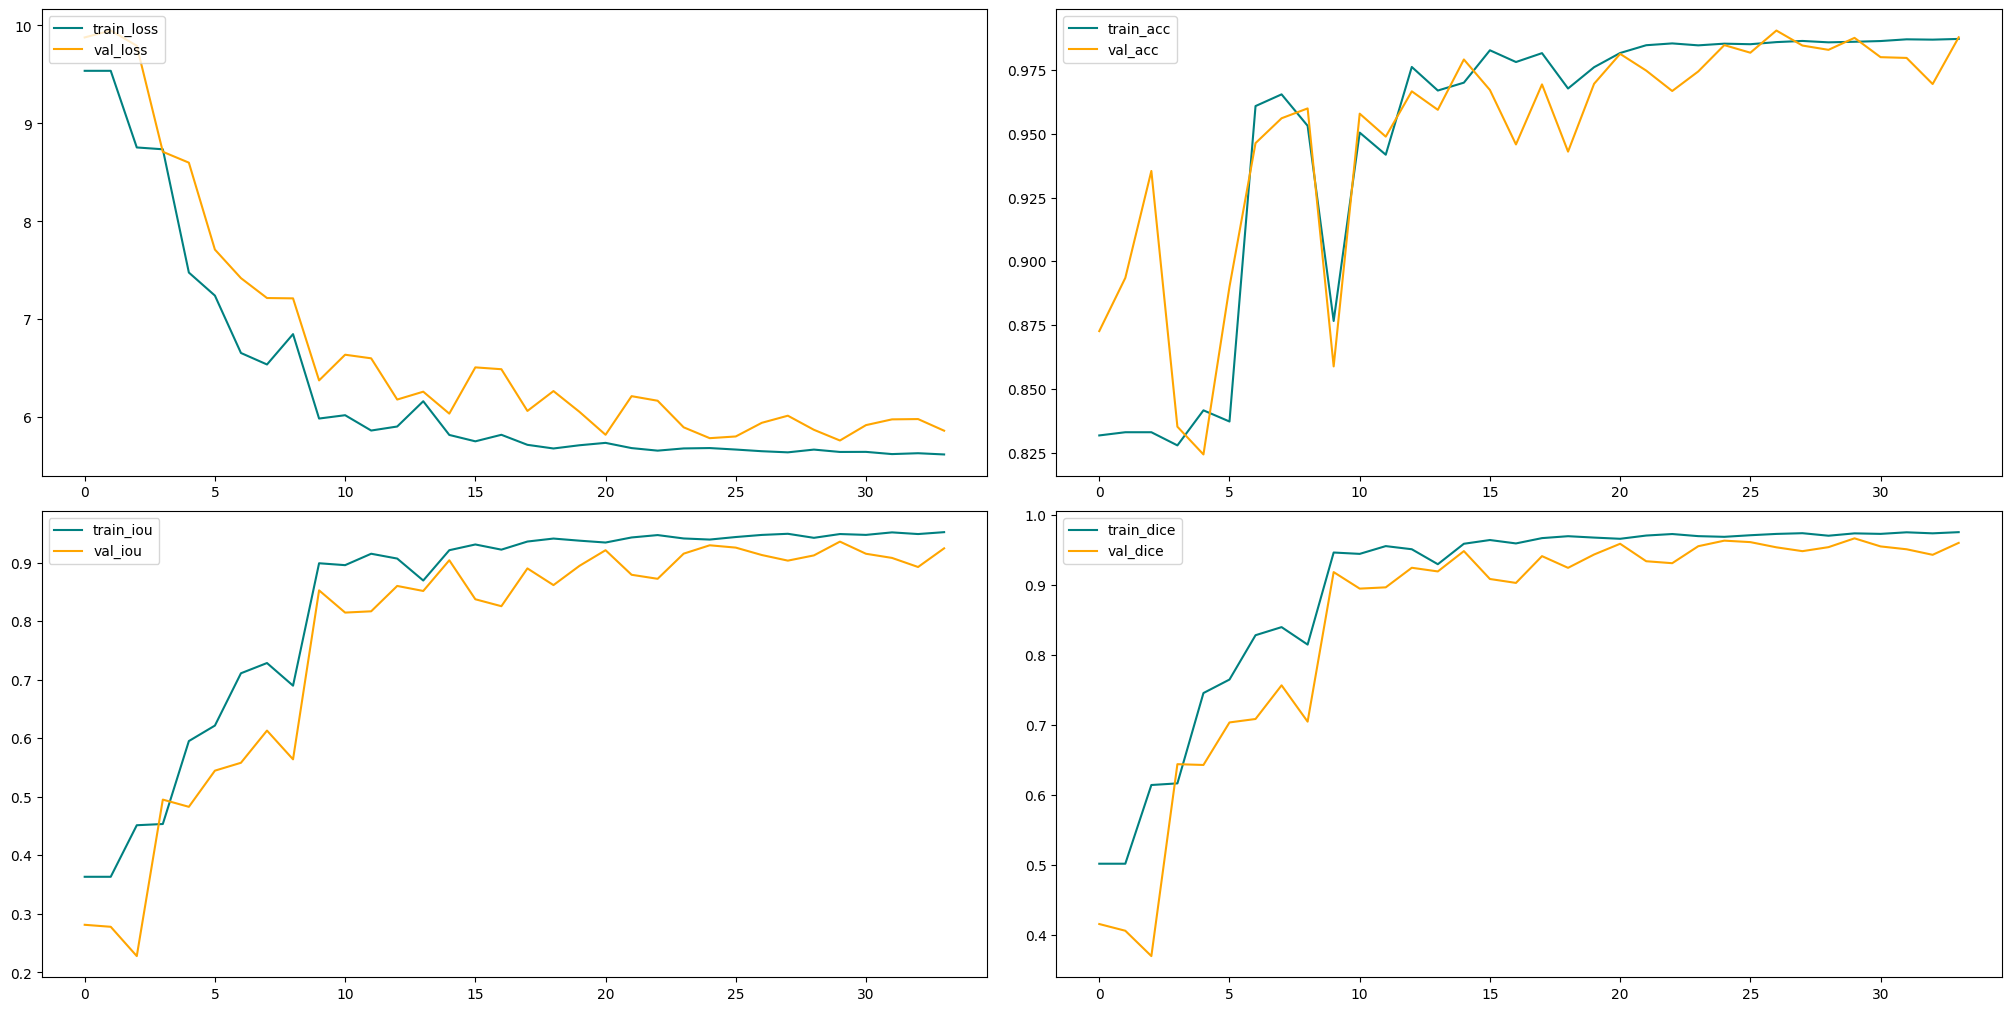

In [13]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(2, 2, constrained_layout = True)
epochs = [_ for _ in range(len(train_losses))]

axs[0][0].plot(epochs, train_losses, color='teal', label='train_loss')
axs[0][0].plot(epochs, val_losses, color='orange', label='val_loss')
axs[0][0].legend(loc='upper left')

axs[0][1].plot(epochs, train_accs, color='teal', label='train_acc')
axs[0][1].plot(epochs, val_accs, color='orange', label='val_acc')
axs[0][1].legend(loc='upper left')

axs[1][0].plot(epochs, train_ious, color='teal', label='train_iou')
axs[1][0].plot(epochs, val_ious, color='orange', label='val_iou')
axs[1][0].legend(loc='upper left')

axs[1][1].plot(epochs, train_dices, color='teal', label='train_dice')
axs[1][1].plot(epochs, val_dices, color='orange', label='val_dice')
axs[1][1].legend(loc='upper left')

## 2.2 Visualisation of segmentation map

In [14]:
def output_to_segmap(output_nparray, threshold = 0.5):
    
    """Converts model's output, a numpy array, into a segmentation map 
    
    Args:
        output_nparray: numpy array, model's output
        threshold: float, scalar to threshold predicted probability
    Returns:
        output_segmap: numpy array, segmentation map of model's output
    """
    output_segmap = np.argmax(output_nparray, axis = -1)
    output_segmap = output_segmap*255.
    return output_segmap

Text(0.5, 1.0, 'Epoch 100')

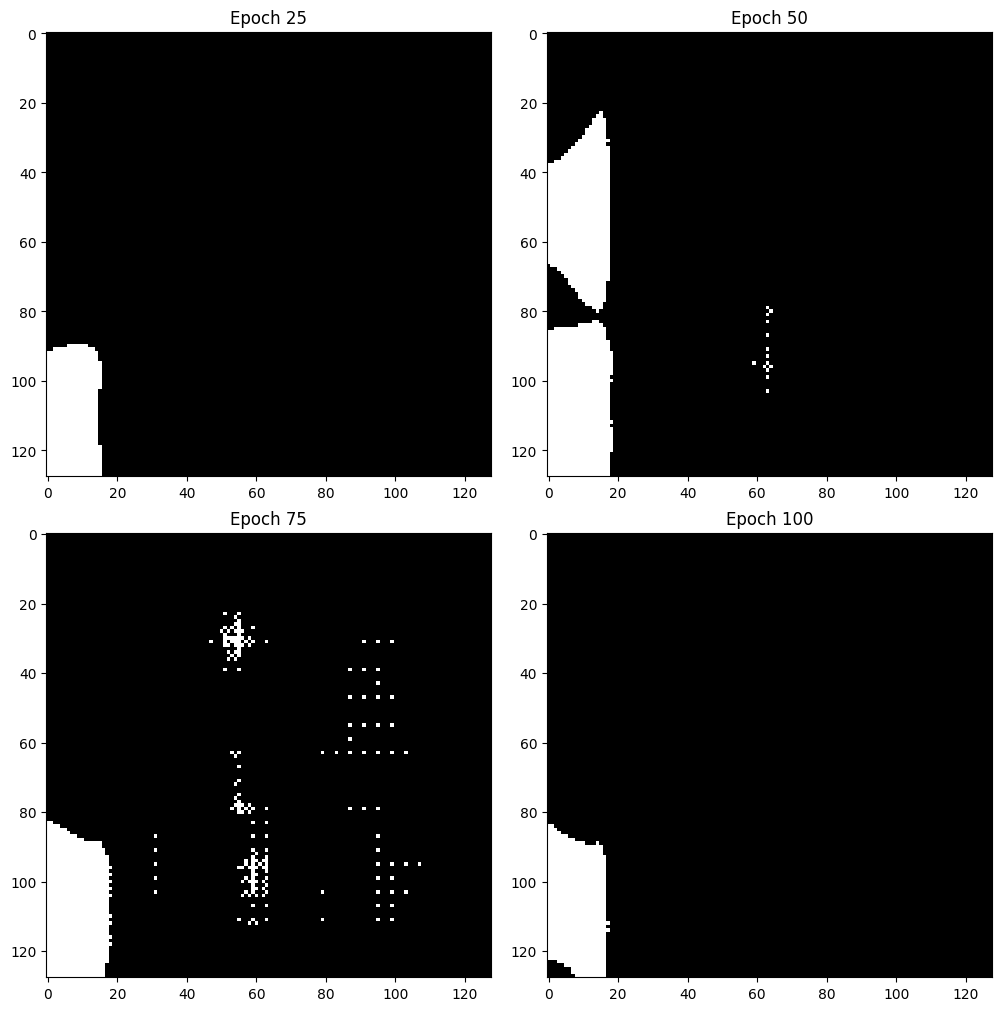

In [15]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(2, 2, constrained_layout = True)

axs[0][0].imshow(output_to_segmap(np.load('train_epoch_25.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[0][0].set_title('Epoch 25')

axs[0][1].imshow(output_to_segmap(np.load('train_epoch_50.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[0][1].set_title('Epoch 50')

axs[1][0].imshow(output_to_segmap(np.load('train_epoch_75.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[1][0].set_title('Epoch 75')

axs[1][1].imshow(output_to_segmap(np.load('train_epoch_100.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[1][1].set_title('Epoch 100')

## 2.3. Comparison of predicted segmentation map with groundtruth segmentation map

In [28]:
# Read in images from directory and create tf.data.Dataset
# Get file names
imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'images')
gts_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'groundtruth')

# Since using iou loss, need to one hot encode the groundtruth images
original_dataset = create_dataset(imgs_dir, gts_dir, one_hot = True)

print(f'Loaded data set: {original_dataset}')

Loaded data set: <_MapDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 2), dtype=tf.float32, name=None))>


In [29]:
# Get original images
# Shuffle the dataset
# Seed of 1 for reproducibility
train_prop = 0.9
num_samples = len(original_dataset)

# seed and reshuffle_each_iteration = False to prevent reshuffling after each iteration of dataset for reproducibility
seed = 1
shuffled_dataset = original_dataset.shuffle(buffer_size = num_samples, seed = seed, reshuffle_each_iteration = False)  
print(f'Shuffled data set: {shuffled_dataset}, no. of samples: {len(shuffled_dataset)}')

train_size = int(train_prop*num_samples)
train_dataset = shuffled_dataset.take(train_size)
val_dataset = shuffled_dataset.skip(train_size)
print(f'Train data set: {train_dataset}, no.of samples: {len(train_dataset)}')
print(f'Validation data set: {val_dataset}, no.of samples: {len(val_dataset)}')

Shuffled data set: <_ShuffleDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 2), dtype=tf.float32, name=None))>, no. of samples: 100
Train data set: <_TakeDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 2), dtype=tf.float32, name=None))>, no.of samples: 90
Validation data set: <_SkipDataset element_spec=(TensorSpec(shape=(400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(400, 400, 2), dtype=tf.float32, name=None))>, no.of samples: 10


In [30]:
# Patch validation dataset
len_before_patch = len(val_dataset)
patched_val_dataset = generate_patches(val_dataset, (128,128), 0, True, True)
len_after_patch = len(patched_val_dataset)

In [31]:
# Determine number of patches per image
num_patch_per_image = len_after_patch/len_before_patch
print(num_patch_per_image)

16.0


In [32]:
# Batch patched dataset based on number of patches per image
patched_val_dataset = patched_val_dataset.batch(16)

In [ ]:
# Make into a list for looping through model
original_val_imgs = list(iter(val_dataset.map(lambda img, gt: img))) 
original_val_gts = list(iter(val_dataset.map(lambda img, gt: gt))) 
patched_val_imgs = list(iter(patched_val_dataset.map(lambda img, gt: img)))
patched_val_gts = list(iter(patched_val_dataset.map(lambda img, gt: gt)))

# Original dimensions of image
original_height = 400
original_width = 400
original_channel = 2
reconstructed_imgs = np.zeros(shape = (len_before_patch, original_height, original_width, original_channel), dtype = np.float32)

for img_no, img_patches in enumerate(patched_val_imgs):
    output = cbam_unet_model(img_patches)
    reconstructed_imgs[img_no] = reconstruct_image(output, (128,128,2), (400,400,2), 0, padding = True)

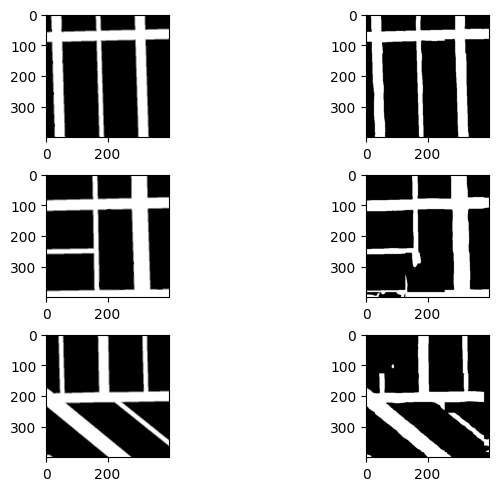

In [37]:
# Visualise groundtruth segmentation map and predicted segmentation map
# Sample first three images to visualise
#val_gt_sample = np.array(val_gts[0])
#print(val_gt_sample.shape)

fig, axs = plt.subplots(3, 2, constrained_layout = True)
val_gt_sample_1 = np.argmax(original_val_gts[2], axis = -1)
val_gt_output_1 = np.argmax(reconstructed_imgs[2], axis = -1)
axs[0][0].imshow(val_gt_sample_1, cmap = 'gray')
axs[0][1].imshow(val_gt_output_1, cmap = 'gray')

val_gt_sample_2 = np.argmax(original_val_gts[4], axis = -1)
val_gt_output_2 = np.argmax(reconstructed_imgs[4], axis = -1)
axs[1][0].imshow(val_gt_sample_2, cmap = 'gray')
axs[1][1].imshow(val_gt_output_2, cmap = 'gray')

val_gt_sample_3 = np.argmax(original_val_gts[8], axis = -1)
val_gt_output_3 = np.argmax(reconstructed_imgs[8], axis = -1)
axs[2][0].imshow(val_gt_sample_3, cmap = 'gray')
axs[2][1].imshow(val_gt_output_3, cmap = 'gray')